In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd 
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time


plt.ion()

In [3]:
all_dir = '/kaggle/input/journey-springfield/train/simpsons_dataset'

In [4]:
#сохраним отдельно список меток, которые соответствуют названию папок

import os
class_names = []
for dirname, _, filenames in os.walk('/kaggle/input/journey-springfield/train/simpsons_dataset/'):
    class_names.append(os.path.split(dirname)[-1])
class_names = sorted(class_names[1:])
len(class_names)
 

42

In [5]:
#разделим выборку на обучающую и валидационную

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

#class_names = ['cleaned', 'dirty']
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(all_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 181/181 [00:00<00:00, 431.74it/s]


In [6]:
#применим аугментацию

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(2179, 17426)

In [8]:
len(val_dataloader), len(val_dataset)

(439, 3507)

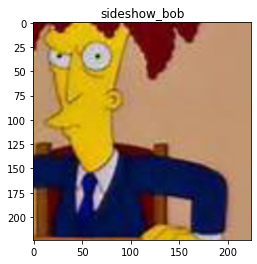

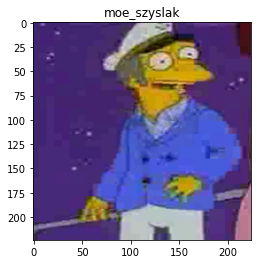

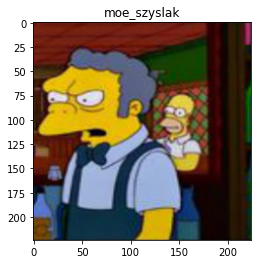

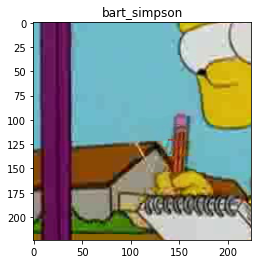

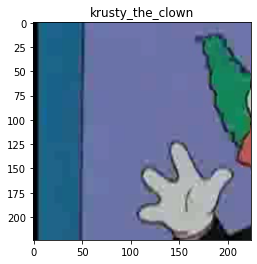

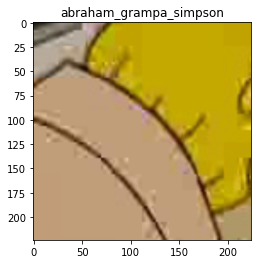

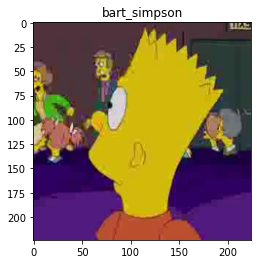

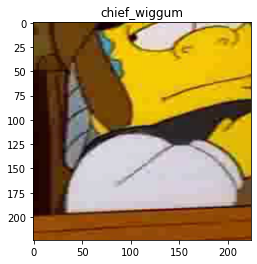

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                dataset = train_dataset
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                dataloader = val_dataloader
                dataset = val_dataset
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloader:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects / len(dataset)
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [11]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in val_dataloader:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / len(val_dataset)

In [12]:
model = models.vgg16(pretrained=True)      

# for param in model.parameters(): #замораживаем параметры
#     param.requires_grad = False

layers_to_unfreeze = 15

# Выключаем подсчет градиентов для слоев, которые не будем обучать
# for param in model.features[:-layers_to_unfreeze].parameters():
#     param.requires_grad = False

#model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [13]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088 #9216 alexnet,  25088 vgg
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

use_gpu = torch.cuda.is_available()
# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  #classifier.
# optimizer_ft = optim.SGD(list(model.features.parameters())[-layers_to_unfreeze:] + 
#                          list(model.classifier.parameters()), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.5 каждые 7 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

In [14]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1998 Acc: 0.5776
val Loss: 0.0750 Acc: 0.8400

Epoch 1/24
----------
train Loss: 0.1163 Acc: 0.7604
val Loss: 0.0535 Acc: 0.8896

Epoch 2/24
----------
train Loss: 0.0935 Acc: 0.8080
val Loss: 0.0401 Acc: 0.9202

Epoch 3/24
----------
train Loss: 0.0827 Acc: 0.8285
val Loss: 0.0432 Acc: 0.9187

Epoch 4/24
----------
train Loss: 0.0757 Acc: 0.8414
val Loss: 0.0288 Acc: 0.9430

Epoch 5/24
----------
train Loss: 0.0696 Acc: 0.8537
val Loss: 0.0328 Acc: 0.9370

Epoch 6/24
----------
train Loss: 0.0564 Acc: 0.8844
val Loss: 0.0235 Acc: 0.9575

Epoch 7/24
----------
train Loss: 0.0530 Acc: 0.8874
val Loss: 0.0261 Acc: 0.9492

Epoch 8/24
----------
train Loss: 0.0498 Acc: 0.8979
val Loss: 0.0231 Acc: 0.9589

Epoch 9/24
----------
train Loss: 0.0500 Acc: 0.8931
val Loss: 0.0241 Acc: 0.9547

Epoch 10/24
----------
train Loss: 0.0495 Acc: 0.8956
val Loss: 0.0223 Acc: 0.9587

Epoch 11/24
----------
train Loss: 0.0470 Acc: 0.9007
val Loss: 0.0214 Acc: 0.9578

Epoch 12/24
----------
t

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.cuda()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
from sklearn.metrics import f1_score

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]
probs = predict(model, val_dataloader)
preds = np.argmax(probs,-1)
f1_score(actual_labels, preds, average='micro')

0.9686341602509267

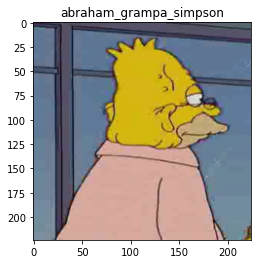

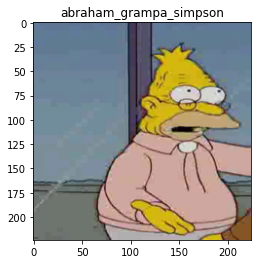

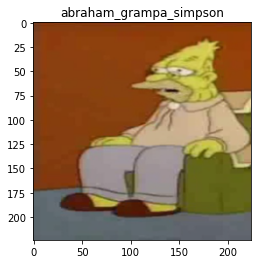

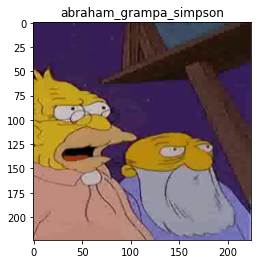

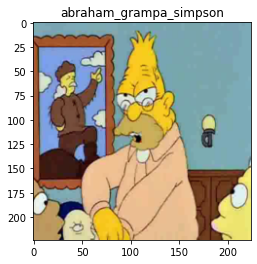

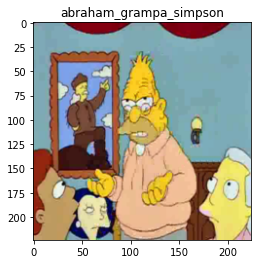

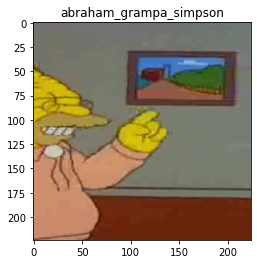

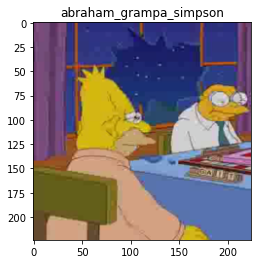

In [18]:
inputs, labels = next(iter(val_dataloader))

for img, pred in zip(inputs, preds):
    show_input(img, title=class_names[pred])

In [19]:
test_dir = '/kaggle/input/journey-springfield/testset/'
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [20]:
probs = predict(model, test_dataloader)
preds = np.argmax(probs,-1)
preds_in = []
for pred in preds:
    preds_in.append(class_names[pred])

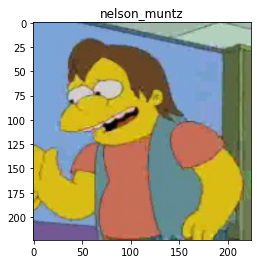

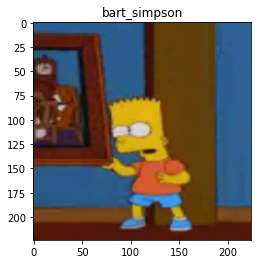

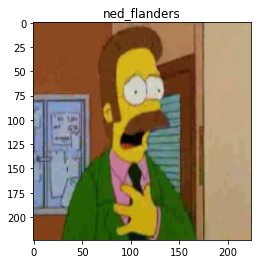

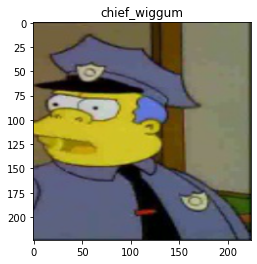

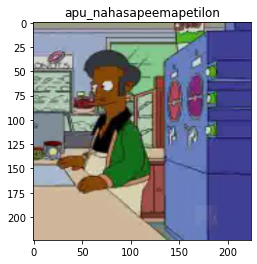

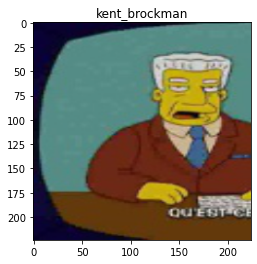

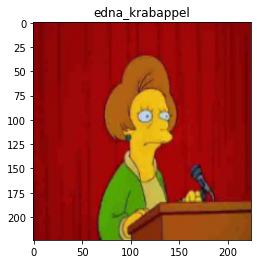

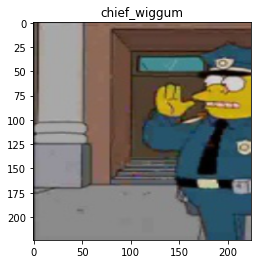

In [21]:
inputs, labels = next(iter(test_dataloader))

for img, pred in zip(inputs, preds):
    show_input(img, title=class_names[pred])

In [22]:
test_names = []
for dirname, _, filenames in os.walk('/kaggle/input/journey-springfield/testset/testset/'):
    test_names = filenames
    break
test_names.sort()

In [23]:
submit = pd.read_csv('/kaggle/input/journey-springfield/sample_submission.csv')
submit['Id'] = test_names
submit['Expected'] = preds_in
submit.to_csv('submission.csv', index=False)
submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [24]:
# shutil.rmtree("/kaggle/working/train")
# shutil.rmtree("kaggle/working/val")